In [1]:
from google.colab import drive # Mounte personal Gdrive folder
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install earthengine-api matplotlib numpy geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import requests
from io import BytesIO
import geopandas as gpd
from shapely.geometry import shape
import os
import json
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-xiaotan')  # Replace with your Project ID

In [5]:
# Threshold settings
ndvi_threshold = 0.3
ndwi_threshold = 0.1
min_elevation_threshold = 0
max_elevation_threshold = 2500
max_slope_threshold = 15
min_area_threshold = 1000

# Define output directory path
output_path = '/content/drive/MyDrive/GP_Project'

# Initialize map
Map = geemap.Map(center=[45.98, 9.26], zoom=12)
Map

Map(center=[45.45, 9.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [15]:
# Select the last feature drawn on the map

"""
Important:
- The selected Region of Interest (ROI) should be within the extent of a single Sentinel-2 tile (~100x100 km).
- This code only supports data from one tile. If the ROI spans multiple tiles, the Sentinel-2 data loading process will fail.
"""

feature = Map.draw_last_feature

# Define Region of Interest (ROI) using the feature's geometry
roi = feature.geometry()

ROI Center Longitude: 9.262633000004522, Latitude: 45.98634668231585


### *I. NDVI*  

NDVI Min: -0.07948800921440125, NDVI Max: 0.48254677653312683


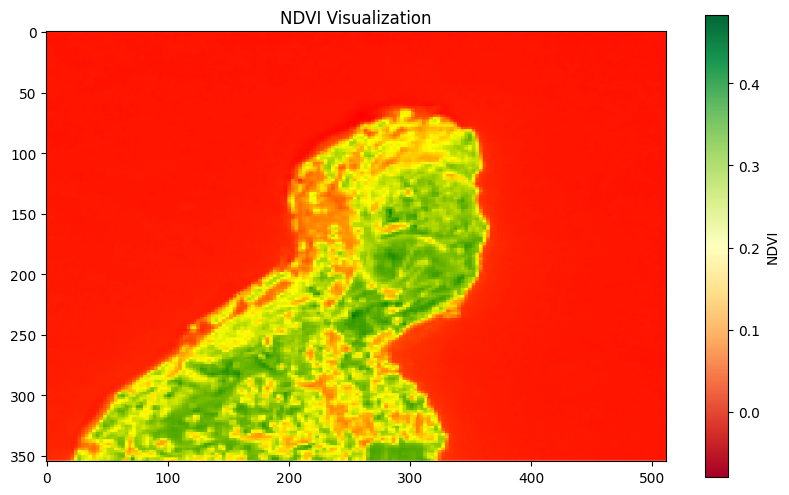

In [7]:
# Load Sentinel-2 data
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2022-01-01', '2023-12-31') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# Get projection and CRS
projection = sentinel2.first().select('B4').projection()
crs_info = projection.getInfo()['crs']

# Add NDVI band
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

sentinel2_with_ndvi = sentinel2.map(calculate_ndvi)

# Calculate mean NDVI
ndvi_mean = sentinel2_with_ndvi.select('NDVI').mean().clip(roi)

# Get NDVI range
ndvi_stats = ndvi_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    bestEffort=True
)
ndvi_min = ndvi_stats.get('NDVI_min').getInfo()
ndvi_max = ndvi_stats.get('NDVI_max').getInfo()

print(f"NDVI Min: {ndvi_min}, NDVI Max: {ndvi_max}")

# Visualize NDVI
url = ndvi_mean.getThumbURL({
    'min': ndvi_min,
    'max': ndvi_max,
    'dimensions': 512,
    'palette': ['red', 'yellow', 'green']
})

response = requests.get(url)
img = mpimg.imread(BytesIO(response.content))

plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='RdYlGn', vmin=ndvi_min, vmax=ndvi_max)
plt.colorbar(label="NDVI")
plt.title("NDVI Visualization")
plt.show()


### *II. NDWI*  

NDWI Min: -0.40952977538108826, NDWI Max: 0.17430754005908966


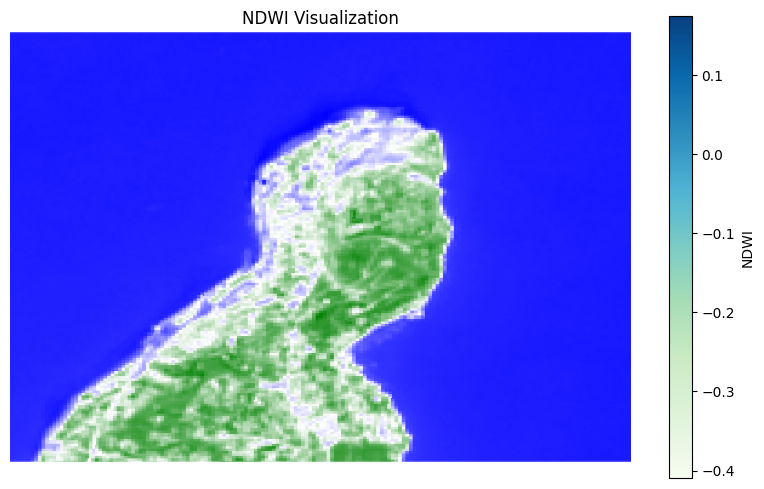

In [8]:
# Add NDWI band
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

sentinel2_with_ndwi = sentinel2.map(calculate_ndwi)

# Compute mean NDWI clipped to ROI
ndwi_mean = sentinel2_with_ndwi.select('NDWI').mean().clip(roi)

# Get NDWI range
ndwi_stats = ndwi_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    bestEffort=True
)
ndwi_min = ndwi_stats.get('NDWI_min').getInfo()
ndwi_max = ndwi_stats.get('NDWI_max').getInfo()

# Visualize NDWI
url_ndwi = ndwi_mean.getThumbURL({
    'min': ndwi_min,
    'max': ndwi_max,
    'dimensions': 512,
    'palette': ['green', 'white', 'blue']
})

print(f"NDWI Min: {ndwi_min}, NDWI Max: {ndwi_max}")

response_ndwi = requests.get(url_ndwi)
img_ndwi = mpimg.imread(BytesIO(response_ndwi.content))

plt.figure(figsize=(10, 6))
plt.imshow(img_ndwi, cmap='GnBu', vmin=ndwi_min, vmax=ndwi_max)
plt.colorbar(label="NDWI")
plt.title("NDWI Visualization")
plt.axis('off')
plt.show()

### *III. DTM*  

Elevation Min: 195, Elevation Max: 336


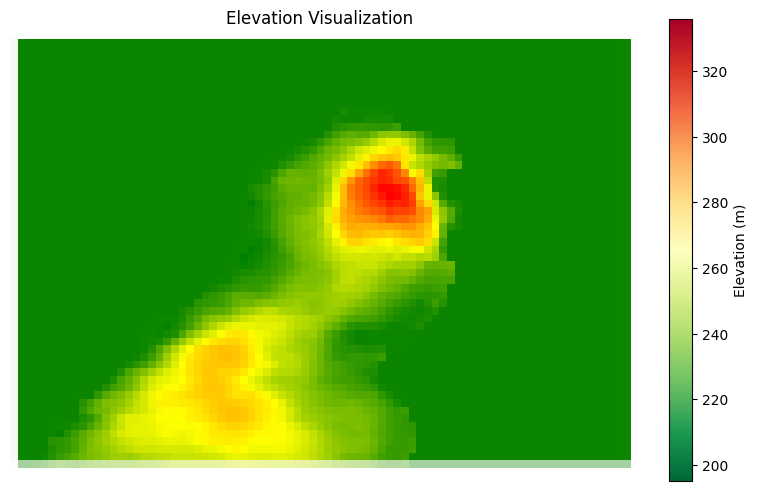

In [9]:
# Load elevation data (SRTM or Copernicus DEM)
elevation = ee.Image('USGS/SRTMGL1_003')

# Clip elevation data to ROI
elevation_clipped = elevation.clip(roi)

# Get elevation range
elevation_stats = elevation_clipped.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=30,
    bestEffort=True
)
elevation_min = elevation_stats.get('elevation_min').getInfo()
elevation_max = elevation_stats.get('elevation_max').getInfo()

# Visualize elevation
url_elevation = elevation_clipped.getThumbURL({
    'min': elevation_min,
    'max': elevation_max,
    'palette': ['green', 'yellow', 'red']
})
print(f"Elevation Min: {elevation_min}, Elevation Max: {elevation_max}")

response_elevation = requests.get(url_elevation)
img_elevation = mpimg.imread(BytesIO(response_elevation.content))

plt.figure(figsize=(10, 6))
plt.imshow(img_elevation, cmap='RdYlGn_r', vmin=elevation_min, vmax=elevation_max)
plt.colorbar(label="Elevation (m)")
plt.title("Elevation Visualization")
plt.axis('off')
plt.show()

### *IV. Slope*  

Slope Min: 0, Slope Max: 62.205909729003906


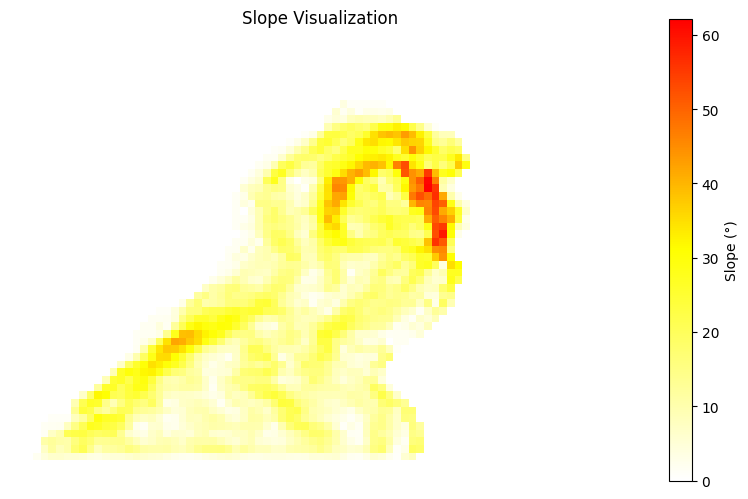

In [10]:
from matplotlib.colors import LinearSegmentedColormap

# Compute and clip slope to ROI
slope_clipped = ee.Terrain.slope(elevation_clipped).clip(roi)

# Get slope range
slope_stats = slope_clipped.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=30,
    bestEffort=True
)
slope_min = slope_stats.get('slope_min').getInfo()
slope_max = slope_stats.get('slope_max').getInfo()

print(f"Slope Min: {slope_min}, Slope Max: {slope_max}")

# Visualize slope
url_slope = slope_clipped.getThumbURL({
    'min': slope_min,
    'max': slope_max,
    'palette': ['white', 'yellow', 'red']
})

response_slope = requests.get(url_slope)
img_slope = mpimg.imread(BytesIO(response_slope.content))

# Define custom colormap matching GEE palette
white_yellow_red = LinearSegmentedColormap.from_list(
    'white_yellow_red', ['white', 'yellow', 'red'], N=256)

plt.figure(figsize=(10, 6))
plt.imshow(img_slope, cmap=white_yellow_red, vmin=slope_min, vmax=slope_max)
plt.colorbar(label="Slope (°)")
plt.title("Slope Visualization")
plt.axis('off')
plt.show()

### *V. Mask*  

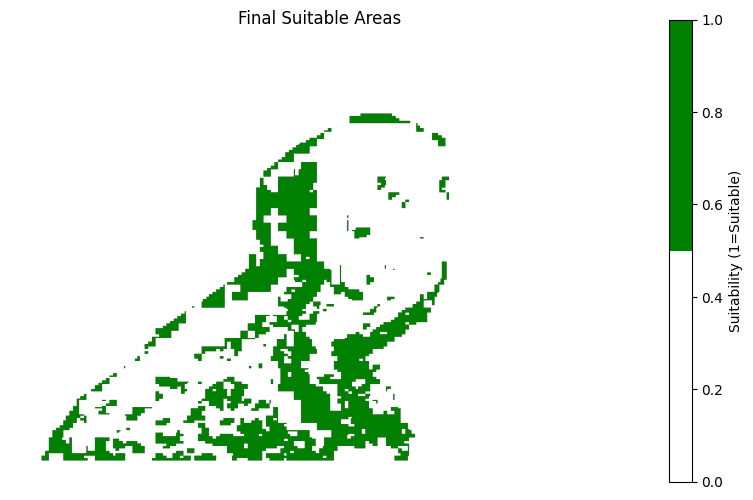

In [11]:
# Define filter functions
def filter_vegetation(ndvi_image, threshold):
    return ndvi_image.lte(threshold)

def filter_water(ndwi_image, threshold):
    return ndwi_image.lte(threshold)

def filter_elevation(elevation_image, min_elevation, max_elevation):
    return elevation_image.gte(min_elevation).And(elevation_image.lte(max_elevation))

def filter_slope(slope_image, max_slope):
    return slope_image.lte(max_slope)

# Apply filters
vegetation_mask = filter_vegetation(ndvi_mean, ndvi_threshold)
water_mask = filter_water(ndwi_mean, ndwi_threshold)
elevation_mask = filter_elevation(elevation_clipped, min_elevation_threshold, max_elevation_threshold)
slope_mask = filter_slope(slope_clipped, max_slope_threshold)

# Combine all masks
combined_mask = vegetation_mask.And(water_mask).And(elevation_mask).And(slope_mask)

# Convert combined_mask to a visualizable image
combined_mask_visual = combined_mask.selfMask()

# Get thumbnail URL for suitable areas
final_mask_url = combined_mask_visual.getThumbURL({
    'min': 0,
    'max': 1,
    'dimensions': 512,
    'palette': ['white', 'green']  # White: Not suitable, Green: Suitable
})

# Fetch the image from the URL
response_final_mask = requests.get(final_mask_url)
final_mask_img = mpimg.imread(BytesIO(response_final_mask.content))

# Plot the suitable areas
plt.figure(figsize=(10, 6))
plt.imshow(final_mask_img, cmap=ListedColormap(['white', 'green']), vmin=0, vmax=1)
plt.colorbar(label="Suitability (1=Suitable)")
plt.title("Final Suitable Areas")
plt.axis('off')
plt.show()

### *VI. Vectorization*  

GeoDataFrame CRS: EPSG:4326
Filtered Area Statistics:
Maximum Area (m²): 2519382.8524270435
Minimum Area (m²): 1249.9673167685658
Mean Area (m²): 114425.93198950676
Total Area (m²): 2860648.299737669
Number of Regions: 25


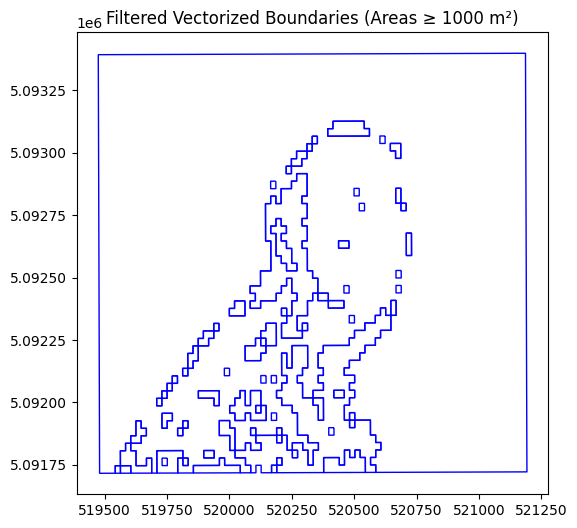

In [12]:


# Vectorize combined_mask with reduceToVectors()
vector_mask = combined_mask.reduceToVectors(
    reducer=ee.Reducer.countEvery(),
    geometry=roi,
    scale=30,
    maxPixels=1e8,
    crs='EPSG:4326'
)

# Convert vectorized result to GeoDataFrame
features = vector_mask.getInfo()['features']
geometries = [shape(feature['geometry']) for feature in features]
gdf = gpd.GeoDataFrame({'geometry': geometries}, crs='EPSG:4326')
print("GeoDataFrame CRS:", gdf.crs)

# Reproject GeoDataFrame to the same CRS as the data
gdf = gdf.to_crs(crs_info)

# Calculate the area of each polygon (in square meters)
gdf['area'] = gdf['geometry'].area

# Filter polygons with an area >= 1000 square meters
min_area_threshold = 1000
filtered_gdf = gdf[gdf['area'] >= min_area_threshold]

# Print statistics for the area data
area_stats = {
    'Maximum Area (m²)': filtered_gdf['area'].max(),
    'Minimum Area (m²)': filtered_gdf['area'].min(),
    'Mean Area (m²)': filtered_gdf['area'].mean(),
    'Total Area (m²)': filtered_gdf['area'].sum(),
    'Number of Regions': len(filtered_gdf)
}

print("Filtered Area Statistics:")
for stat, value in area_stats.items():
    print(f"{stat}: {value}")

# Plot filtered vectorized boundaries
fig, ax = plt.subplots(figsize=(10, 6))
filtered_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
ax.set_title("Filtered Vectorized Boundaries (Areas ≥ 1000 m²)")
plt.show()


### *VII. Save and Map*  

In [13]:
# Create output directory and file path
output_dir = os.path.join(output_path, "output")
output_file = os.path.join(output_dir, "building_area.geojson")

# Check and create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save GeoDataFrame as GeoJSON file
filtered_gdf.to_file(output_file, driver="GeoJSON")
print(f"Data saved to: {output_file}")

# Load GeoJSON data from file and read as GeoDataFrame
gdf = gpd.read_file(output_file)

# Reproject GeoDataFrame to EPSG:4326 if necessary
if gdf.crs.to_string() != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")
    print("CRS converted to EPSG:4326")

# Convert GeoDataFrame to GeoJSON data
geojson_data = json.loads(gdf.to_json())

# Add GeoJSON data to the map
Map.add_geojson(
    geojson_data,
    layer_name="Building Areas",
    style={
        "color": "red",
        "weight": 2,
        "fillOpacity": 0.4
    }
)

# Display map
Map

Data saved to: /content/drive/MyDrive/GP_Project/output/building_area.geojson
CRS converted to EPSG:4326


Map(bottom=1492626.0, center=[45.990879403392555, 9.26301956176758], controls=(WidgetControl(options=['positio…